In [63]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
import plotly.graph_objs as go
import os
import plotly.offline as py
from sklearn.impute import SimpleImputer
from sklearn.impute import KNNImputer
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn import linear_model
from sklearn.preprocessing import MinMaxScaler

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.float_format', lambda x: '%.3f' % x)
pd.set_option('display.width', 500)

In [64]:
os.chdir("C:\\Users\\HP\\Desktop\\code challenges\\datasets")

In [65]:
df = pd.read_csv("diabetes.csv")

In [66]:
df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.600,0.627,50,1
1,1,85,66,29,0,26.600,0.351,31,0
2,8,183,64,0,0,23.300,0.672,32,1
3,1,89,66,23,94,28.100,0.167,21,0
4,0,137,40,35,168,43.100,2.288,33,1


In [67]:
df.rename(columns ={"DiabetesPedigreeFunction":"DPF"},inplace=True)

In [68]:
df.describe([0.01, 0.05, 0.75, 0.90, 0.99]).T

,count,mean,std,min,1%,5%,50%,75%,90%,99%,max
Pregnancies,768.000,3.845,3.370,0.000,0.000,0.000,3.000,6.000,9.000,13.000,17.000
Glucose,768.000,120.895,31.973,0.000,57.000,79.000,117.000,140.250,167.000,196.000,199.000
BloodPressure,768.000,69.105,19.356,0.000,0.000,38.700,72.000,80.000,88.000,106.000,122.000
SkinThickness,768.000,20.536,15.952,0.000,0.000,0.000,23.000,32.000,40.000,51.330,99.000
Insulin,768.000,79.799,115.244,0.000,0.000,0.000,30.500,127.250,210.000,519.900,846.000
BMI,768.000,31.993,7.884,0.000,0.000,21.800,32.000,36.600,41.500,50.759,67.100
DPF,768.000,0.472,0.331,0.078,0.095,0.140,0.372,0.626,0.879,1.698,2.420
Age,768.000,33.241,11.760,21.000,21.000,21.000,29.000,41.000,51.000,67.000,81.000
Outcome,768.000,0.349,0.477,0.000,0.000,0.000,0.000,1.000,1.000,1.000,1.000


In [69]:
df[['Glucose','BloodPressure','SkinThickness','Insulin','BMI']] = df[['Glucose','BloodPressure','SkinThickness','Insulin','BMI']].replace(0,np.NaN)
df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DPF,Age,Outcome
0,6,148.000,72.000,35.000,NaN,33.600,0.627,50,1
1,1,85.000,66.000,29.000,NaN,26.600,0.351,31,0
2,8,183.000,64.000,NaN,NaN,23.300,0.672,32,1
3,1,89.000,66.000,23.000,94.000,28.100,0.167,21,0
4,0,137.000,40.000,35.000,168.000,43.100,2.288,33,1


In [70]:
def missing_plot(dataset, key) :
    null_feat = pd.DataFrame(len(dataset[key]) - dataset.isnull().sum(), columns = ['Count'])
    percentage_null = pd.DataFrame((len(dataset[key]) - (len(dataset[key]) - dataset.isnull().sum()))/len(dataset[key])*100, columns = ['Count'])
    percentage_null = percentage_null.round(2)

    trace = go.Bar(x = null_feat.index, y = null_feat['Count'] ,opacity = 0.8, text = percentage_null['Count'],  textposition = 'auto',marker=dict(color = '#7EC0EE',
            line=dict(color='#000000',width=1.5)))

    layout = dict(title =  "Missing Values (count & %)")

    fig = dict(data = [trace], layout=layout)
    py.iplot(fig)

In [71]:
missing_plot(df, 'Outcome')

In [72]:
def missing_percent(df):
        mis_val = df.isnull().sum()
        mis_percent = 100 * df.isnull().sum() / len(df)
        mis_table = pd.concat([mis_val, mis_percent], axis=1)
        mis_columns = mis_table.rename(
        columns = {0 : 'Missing Values', 1 : 'Percent of Total Values'})
        

        mis_columns = mis_columns[
            mis_columns.iloc[:,1] != 0].sort_values(
        'Percent of Total Values', ascending=False).round(2)
        
        
        print ("Your selected dataframe has " + str(df.shape[1]) + " columns.\n"      
            "There are " + str(mis_columns.shape[0]) +
              " columns that have missing values.")
        
        
        return mis_columns

In [73]:
miss_cols_info = missing_percent(df)
miss_cols_info

Your selected dataframe has 9 columns.
There are 5 columns that have missing values.


,Missing Values,Percent of Total Values
Insulin,374,48.700
SkinThickness,227,29.560
BloodPressure,35,4.560
BMI,11,1.430
Glucose,5,0.650


In [74]:
# KNN IMPUTATION 
df_knn = df.copy()

In [75]:
df_knn.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DPF,Age,Outcome
0,6,148.000,72.000,35.000,NaN,33.600,0.627,50,1
1,1,85.000,66.000,29.000,NaN,26.600,0.351,31,0
2,8,183.000,64.000,NaN,NaN,23.300,0.672,32,1
3,1,89.000,66.000,23.000,94.000,28.100,0.167,21,0
4,0,137.000,40.000,35.000,168.000,43.100,2.288,33,1


In [76]:
df_knn = df_knn.filter(['Pregnancies','Glucose','BloodPressure','BMI','DPF','Age','Insulin'], axis=1).copy()
df_knn.head()

,Pregnancies,Glucose,BloodPressure,BMI,DPF,Age,Insulin
0,6,148.000,72.000,33.600,0.627,50,NaN
1,1,85.000,66.000,26.600,0.351,31,NaN
2,8,183.000,64.000,23.300,0.672,32,NaN
3,1,89.000,66.000,28.100,0.167,21,94.000
4,0,137.000,40.000,43.100,2.288,33,168.000


In [77]:
scaler = MinMaxScaler(feature_range=(0, 1))
df_knn = pd.DataFrame(scaler.fit_transform(df_knn), columns = df_knn.columns)


knn_imputer = KNNImputer(n_neighbors=5, weights='uniform', metric='nan_euclidean')
df_knn_imputed = pd.DataFrame(knn_imputer.fit_transform(df_knn), columns=df_knn.columns)

In [78]:
df_knn_imputed.head()

,Pregnancies,Glucose,BloodPressure,BMI,DPF,Age,Insulin
0,0.353,0.671,0.490,0.315,0.234,0.483,0.287
1,0.059,0.265,0.429,0.172,0.117,0.167,0.045
2,0.471,0.897,0.408,0.104,0.254,0.183,0.275
3,0.059,0.290,0.429,0.202,0.038,0.000,0.096
4,0.000,0.600,0.163,0.509,0.944,0.200,0.185


In [79]:
original_data = scaler.inverse_transform(df_knn_imputed)
df_original = pd.DataFrame(original_data, columns=df_knn.columns)

In [80]:
df_original.head()

,Pregnancies,Glucose,BloodPressure,BMI,DPF,Age,Insulin
0,6.000,148.000,72.000,33.600,0.627,50.000,253.200
1,1.000,85.000,66.000,26.600,0.351,31.000,51.600
2,8.000,183.000,64.000,23.300,0.672,32.000,243.000
3,1.000,89.000,66.000,28.100,0.167,21.000,94.000
4,0.000,137.000,40.000,43.100,2.288,33.000,168.000


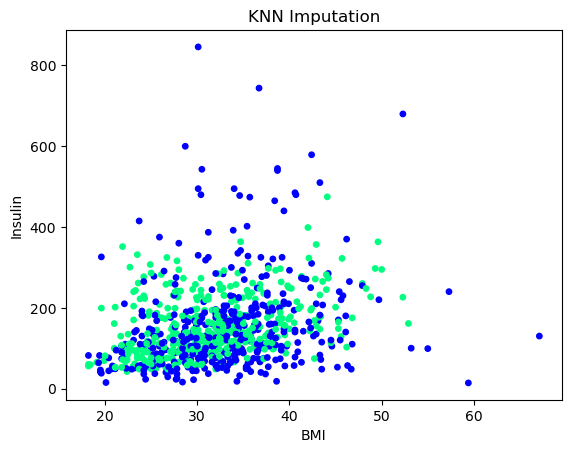

In [81]:
fig = plt.Figure()
null_values = df['Insulin'].isnull() 
fig = df_original.plot(x='BMI', y='Insulin', kind='scatter',
                          c=null_values, cmap='winter', s = 15,
                          title='KNN Imputation', colorbar=False)

Text(0.5, 1.0, 'KNN Imputation')

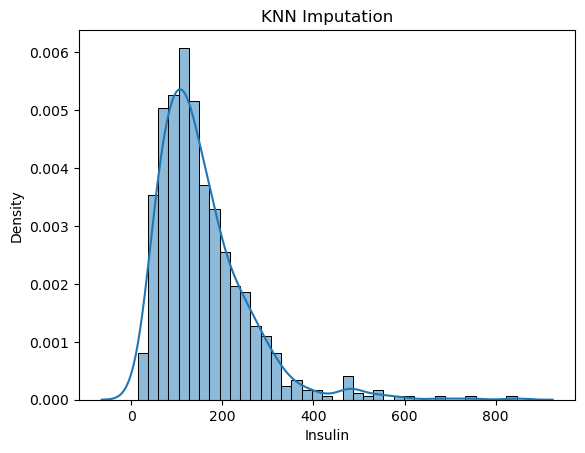

In [82]:
sns.histplot(
    df_original["Insulin"], kde=True,
    stat="density", kde_kws=dict(cut=3)
)
plt.title('KNN Imputation')

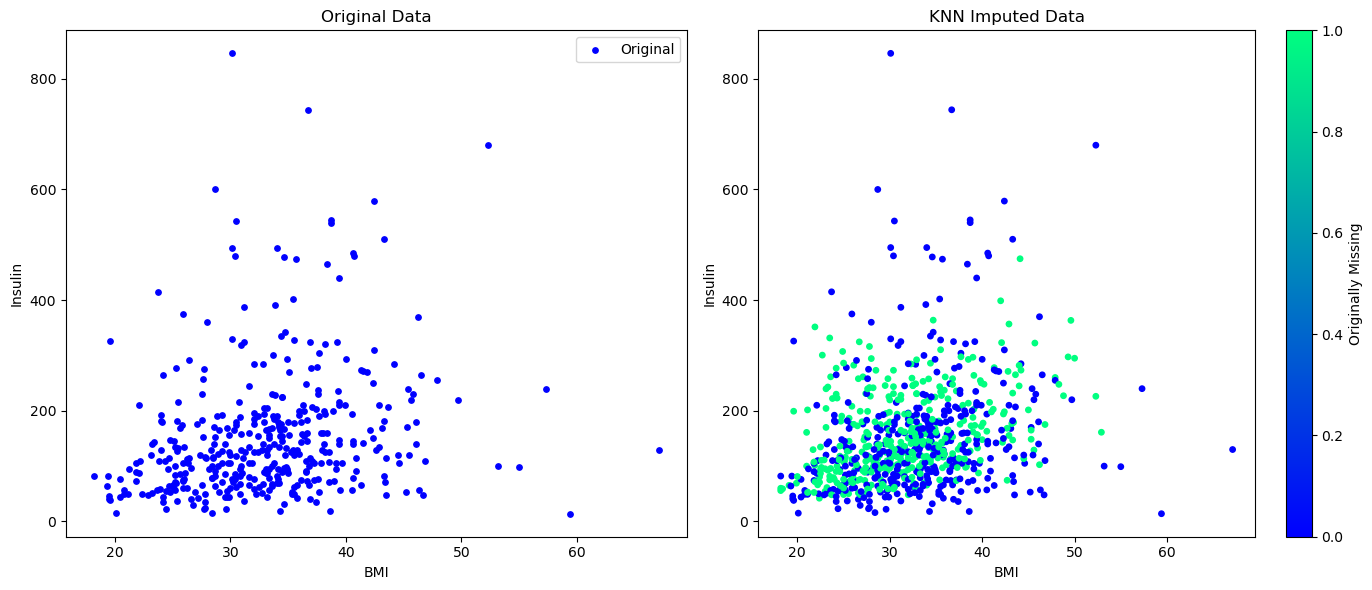

In [83]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(14, 6))
axes[0].scatter(df['BMI'], df['Insulin'], c='blue', label='Original', s=15)
axes[0].set_title('Original Data')
axes[0].set_xlabel('BMI')
axes[0].set_ylabel('Insulin')
axes[0].legend()
null_values = df['Insulin'].isnull()
scatter = axes[1].scatter(df_original['BMI'], df_original['Insulin'], c=null_values, cmap='winter', s=15)
axes[1].set_title('KNN Imputed Data')
axes[1].set_xlabel('BMI')
axes[1].set_ylabel('Insulin')
cbar = plt.colorbar(scatter, ax=axes[1])
cbar.set_label('Originally Missing')

plt.tight_layout()
plt.show()

In [84]:
# mice imputation
df_mice = df.copy()
df_mice.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DPF,Age,Outcome
0,6,148.000,72.000,35.000,NaN,33.600,0.627,50,1
1,1,85.000,66.000,29.000,NaN,26.600,0.351,31,0
2,8,183.000,64.000,NaN,NaN,23.300,0.672,32,1
3,1,89.000,66.000,23.000,94.000,28.100,0.167,21,0
4,0,137.000,40.000,35.000,168.000,43.100,2.288,33,1


In [85]:
df_mice = df.filter(['Pregnancies','Glucose','BloodPressure','BMI','DPF','Age','Insulin'], axis=1).copy()

In [86]:
mice_imputer = IterativeImputer(estimator=linear_model.BayesianRidge(), n_nearest_features=None, imputation_order='ascending')
df_mice_imputed = pd.DataFrame(mice_imputer.fit_transform(df_mice), columns=df_mice.columns)

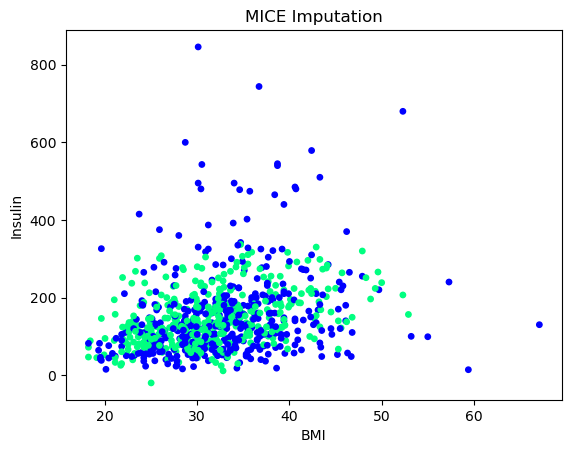

In [87]:
fig = plt.Figure()
null_values = df['Insulin'].isnull() 
fig = df_mice_imputed.plot(x='BMI', y='Insulin', kind='scatter',
                           c=null_values, cmap='winter', s = 15,
                           title='MICE Imputation', colorbar=False)

Text(0.5, 1.0, 'MICE Imputation')

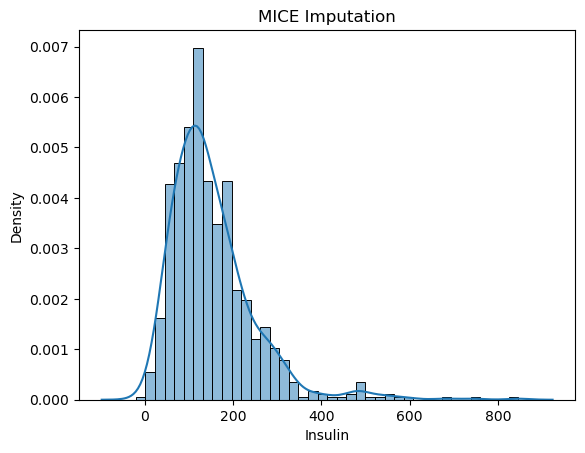

In [88]:
sns.histplot(
    df_mice_imputed["Insulin"], kde=True,
    stat="density", kde_kws=dict(cut=3)
)
plt.title('MICE Imputation')

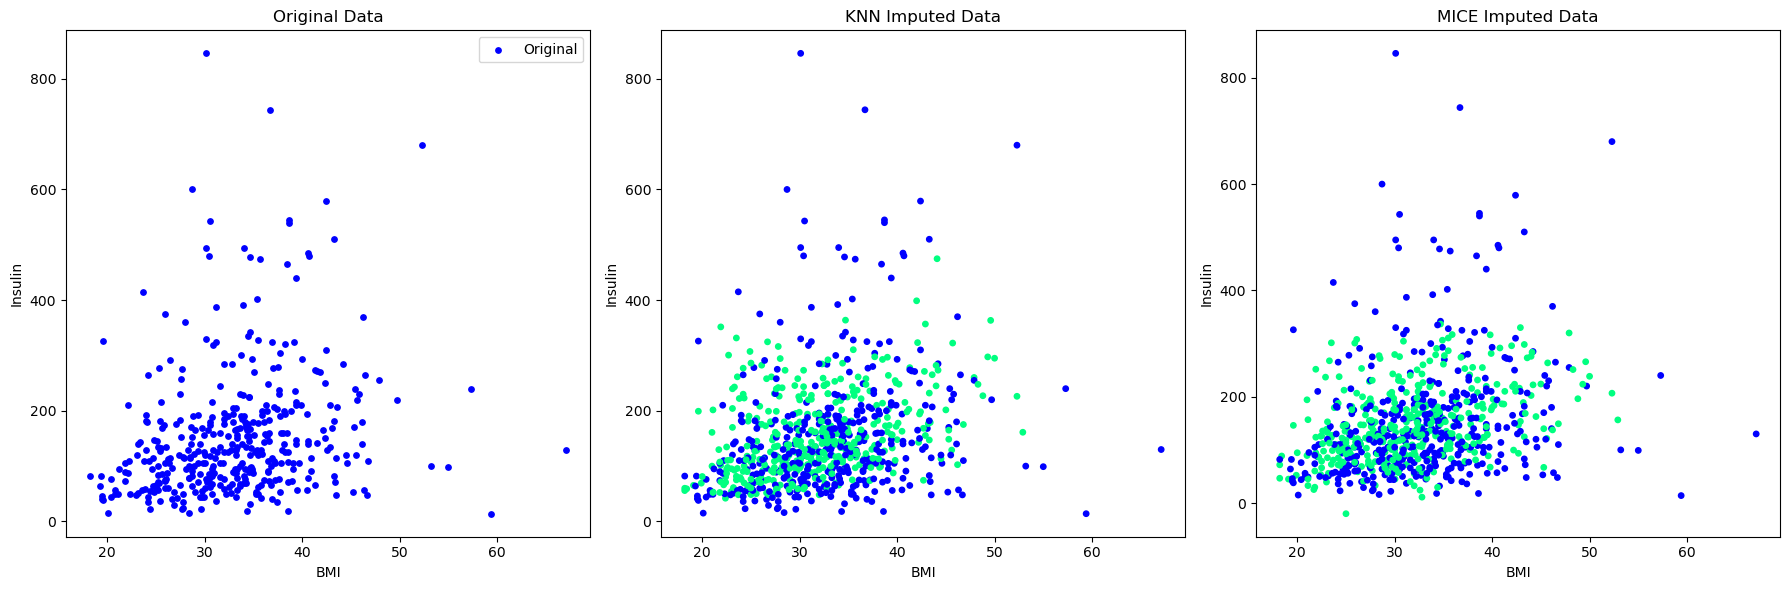

In [89]:
null_values = df['Insulin'].isnull()
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(18, 6))

axes[0].scatter(df['BMI'], df['Insulin'], c='blue', label='Original', s=15)
axes[0].set_title('Original Data')
axes[0].set_xlabel('BMI')
axes[0].set_ylabel('Insulin')
axes[0].legend()

axes[1].scatter(df_original['BMI'], df_original['Insulin'], c=null_values, cmap='winter', s=15)
axes[1].set_title('KNN Imputed Data')
axes[1].set_xlabel('BMI')
axes[1].set_ylabel('Insulin')

axes[2].scatter(df_mice_imputed['BMI'], df_mice_imputed['Insulin'], c=null_values, cmap='winter', s=15)
axes[2].set_title('MICE Imputed Data')
axes[2].set_xlabel('BMI')
axes[2].set_ylabel('Insulin')
plt.tight_layout()
plt.show()

In [90]:
df_knn_ins = pd.Series(df_original["Insulin"], name='KNN_Imp')
df_mice_ins = pd.Series(df_mice_imputed["Insulin"], name='MICE_Imp')

In [91]:
df_all = pd.concat([df_knn_ins,df_mice_ins],axis=1)

In [92]:
df_all.head()

,KNN_Imp,MICE_Imp
0,253.200,218.789
1,51.600,68.766
2,243.000,267.615
3,94.000,94.000
4,168.000,168.000
